# HeadMind Partners XAI Class - Resignation prediction

<img src=https://mma.prnewswire.com/media/1715842/HeadMind_Partners_Logo.jpg width="500">

<img src=https://www.centralesupelec.fr/sites/all/themes/cs_theme/medias/common/images/intro/logo.png width="500">

*Context*

A company faces a large turnover rate and has difficulties to anticipate the resignations. The stakes are numerous : projects are delayed, excessive costs are incurred ... To overcome such a problem, the company decided to implement an AI approach to try to predict the resignations **within the 6 next months**. A confidence score would be really appreciated to estimate the risk of resignations for each employees.

*Dataset*

The HR dataset used for this course is generated from an existing HR dataset. The latter has been anonymized and then artificially generated using a *Variational Auto-Encoder*. Those generated data are gathered in a *pickle* file that will be later on loaded. This *pickle* file is composed of :
- **a pandas DataFrame X** including all the **HR features** needed to implement a ML Model
- **a numpy array Y** representing **the labels**:
    - 0 : the corresponding employee did not resign within the 6 next months
    - 1 : the corresponding employee did resign within the 6 next months


The labels are not well balanced ie there are far less resignated employees within the 6 next months. Decisions must be taken on this matter. On the other hands, many external factors influence the employees' decision which are not necesseraly in the HR dataset.

*Objectives*

- Preprocessing of the input data and HR data exploration
- ML model implementation
- Implement explainability of the predictions using SHAPASH
- Improve the first model considering the explainability outcomes


*Notebook by Rémi Grand and Vadim Becquet (Headmind Partners AI & Blockchain)*

## Import the recommended libraries

In [1]:
# !pip install -r requirements.txt

In [44]:
import pickle
import pandas as pd
import numpy as np
import optuna
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss, roc_auc_score, plot_confusion_matrix, f1_score, recall_score, precision_score
from sklearn.model_selection import train_test_split, KFold
from category_encoders import OneHotEncoder, OrdinalEncoder
from IPython.display import display

plt.style.use('seaborn-whitegrid')
sns.set_theme()

## Load and explore the dataset

The dataset needs to be extracted from the pickle file previously mentionned. **The dataset does not contain missing values** to focus rather on the statistical exploration.

The dataset includes employees from 2016 to 2020. 

In [2]:
# Loading du dataset

PATH = "data/dataset_RH.pkl"

with open(PATH, 'rb') as read_file:
    X, Y = pickle.load(read_file)
X.head()

,Famille d'emploi,Dernière promotion (mois),Dernière augmentation (mois),Début de contrat (années),Ancienneté groupe (années),Etablissement,Âge (années),Parent,Niveau hiérarchique,Salaire (Euros),Statut marital,Véhicule,matricule
0,Production,8.510000,7.900000,0.910000,0.970000,27,30,1,1,3199,Marié(e),0,32
1,Production,35.119999,22.690001,14.830000,16.299999,7,45,1,2,3861,Marié(e),1,1890
2,Production,25.299999,22.139999,17.309999,17.790001,28,49,1,2,4324,PACS,1,1847
3,Production,5.240000,5.100000,1.020000,1.750000,27,24,0,1,2641,Célibataire,0,2619
4,Production,35.919998,22.840000,8.050000,9.000000,7,46,1,2,5072,Marié(e),1,1963


Question : Which features are categorical ? 

In [3]:
# How many samples do we have in our dataset ?
print("Nb of sampels : ", X.shape[0])
# Features distributions : Do you find any outliers ?
print("Nb of non numerical features : ", X.select_dtypes(include=['object']).shape[1])

print("********")
print("Matricule :\n",X.matricule.value_counts())
print("********")

X.describe()

Nb of sampels :  23857
Nb of non numerical features :  2
********
Matricule :
 32      15
2311    15
2242    15
1825    15
77      15
        ..
2629     1
522      1
1643     1
2201     1
1563     1
Name: matricule, Length: 2676, dtype: int64
********


,Dernière promotion (mois),Dernière augmentation (mois),Début de contrat (années),Ancienneté groupe (années),Etablissement,Âge (années),Parent,Niveau hiérarchique,Salaire (Euros),Véhicule,matricule
count,23857.000000,23857.000000,23857.000000,23857.000000,23857.000000,23857.000000,23857.000000,23857.000000,23857.000000,23857.000000,23857.000000
mean,29.460739,7.934986,7.530322,11.632095,20.193947,41.767154,0.720711,1.554554,4168.404032,0.506853,1361.255858
std,25.497874,7.549982,5.985476,9.218618,9.295469,11.014444,0.448659,0.657887,1657.829824,0.500299,794.183153
min,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,0.000000,1.000000,2134.000000,0.000000,0.000000
25%,10.590000,3.180000,2.300000,3.800000,11.000000,34.000000,0.000000,1.000000,3197.000000,0.000000,655.000000
50%,21.219999,5.880000,6.280000,9.870000,26.000000,41.000000,1.000000,1.000000,3629.000000,1.000000,1371.000000
75%,41.400002,10.340000,11.070000,16.320000,28.000000,49.000000,1.000000,2.000000,4511.000000,1.000000,2072.000000
max,152.970001,84.050003,33.119999,45.619999,36.000000,100.000000,1.000000,4.000000,18137.000000,2.000000,2675.000000


The categorical variables are : Famille d'emploi, Statut marital. But it is also important to notice that Etablissement, Parent, Vehicule are also categorical, it is juste an encoding. It is also possible to argui that matricule is categorical since we can't apply any order on it, each person has.

Question: How many different employees are gathered in this dataset?

In [4]:
print("Number of employes : ", X.matricule.nunique())

Number of employes :  2676


In [5]:
print("Lets see the content concerning 1 employe :")
X[X.matricule == 2311].head()

Lets see the content concerning 1 employe :


,Famille d'emploi,Dernière promotion (mois),Dernière augmentation (mois),Début de contrat (années),Ancienneté groupe (années),Etablissement,Âge (années),Parent,Niveau hiérarchique,Salaire (Euros),Statut marital,Véhicule,matricule
244,Support,37.070000,23.020000,7.99,24.540001,19,55,1,2,4825,Marié(e),1,2311
1176,Support,40.299999,25.900000,8.36,24.709999,20,56,1,2,4825,Marié(e),1,2311
2594,Support,43.470001,28.280001,8.73,24.770000,20,56,1,2,4822,Marié(e),1,2311
4134,Support,46.650002,30.680000,9.11,24.850000,20,57,1,2,4819,Marié(e),1,2311
6033,Support,49.840000,33.090000,9.49,24.920000,19,57,1,2,4815,Marié(e),1,2311


Question: How many employees did resignate within the next six months in the dataset ? What is then the proportion of this label ?

In [6]:
X[X.matricule == 1276]

,Famille d'emploi,Dernière promotion (mois),Dernière augmentation (mois),Début de contrat (années),Ancienneté groupe (années),Etablissement,Âge (années),Parent,Niveau hiérarchique,Salaire (Euros),Statut marital,Véhicule,matricule
12997,Production,3.54,2.83,0.47,0.96,2,25,0,1,3251,Célibataire,0,1276
14785,Production,6.30,5.63,0.78,1.05,2,26,0,1,3250,Célibataire,0,1276
16586,Production,9.46,0.87,1.11,1.53,2,27,0,1,3354,Célibataire,0,1276
18398,Production,12.24,3.74,1.37,1.59,2,27,0,1,3352,Célibataire,0,1276
20189,Production,1.78,6.57,1.55,1.80,2,27,0,1,3354,Célibataire,0,1276
21992,Production,4.97,1.63,1.95,2.32,2,28,0,1,3459,Célibataire,0,1276
23761,Production,7.71,4.49,2.20,2.38,2,28,0,1,3457,Célibataire,0,1276


In [7]:
print("Total number of resignations : ", Y.sum())
print("Total number of unique employees resignated :", X[Y.astype(bool)].matricule.nunique())
print("Maximum entries per resignated employees : ", X[Y.astype(bool)].matricule.value_counts().max())
print("Example of repeated resignation in the Y vector : ")
id_resignated = X[Y.astype(bool)].matricule.value_counts().index[0]
X[Y.astype(bool)][X[Y.astype(bool)].matricule == id_resignated]

Total number of resignations :  755
Total number of unique employees resignated : 408
Maximum entries per resignated employees :  3
Example of repeated resignation in the Y vector : 


,Famille d'emploi,Dernière promotion (mois),Dernière augmentation (mois),Début de contrat (années),Ancienneté groupe (années),Etablissement,Âge (années),Parent,Niveau hiérarchique,Salaire (Euros),Statut marital,Véhicule,matricule
20189,Production,1.78,6.57,1.55,1.80,2,27,0,1,3354,Célibataire,0,1276
21992,Production,4.97,1.63,1.95,2.32,2,28,0,1,3459,Célibataire,0,1276
23761,Production,7.71,4.49,2.20,2.38,2,28,0,1,3457,Célibataire,0,1276


Question: Consider a random employee who decided to resignate. Take a look at his evolution in the company from his hiring until his resignation

In [8]:
# HINTS
# idx_resignate = np.where(...)
# rand_idx = ... # Select a random resignation
# resignated_employee = ... # Get the matricule of the randomly picked employee

# evolution_employee = ... # Extract the subdataframe with the feature evolutions of the resignated employees
id_resignated = X[Y.astype(bool)].matricule.value_counts().index[0]
X[Y.astype(bool)][X[Y.astype(bool)].matricule == id_resignated]

,Famille d'emploi,Dernière promotion (mois),Dernière augmentation (mois),Début de contrat (années),Ancienneté groupe (années),Etablissement,Âge (années),Parent,Niveau hiérarchique,Salaire (Euros),Statut marital,Véhicule,matricule
20189,Production,1.78,6.57,1.55,1.80,2,27,0,1,3354,Célibataire,0,1276
21992,Production,4.97,1.63,1.95,2.32,2,28,0,1,3459,Célibataire,0,1276
23761,Production,7.71,4.49,2.20,2.38,2,28,0,1,3457,Célibataire,0,1276


### Using seaborn to explore data 

As studied previously, the features are evolving for each employees in the time period 2016-2020. This evolution could be modeled as a time series experiment. In the first place, we will focus on classic ML models.

Correlation matrixes and features distributions according to the resignation decision are displayed using the *seaborn* library.

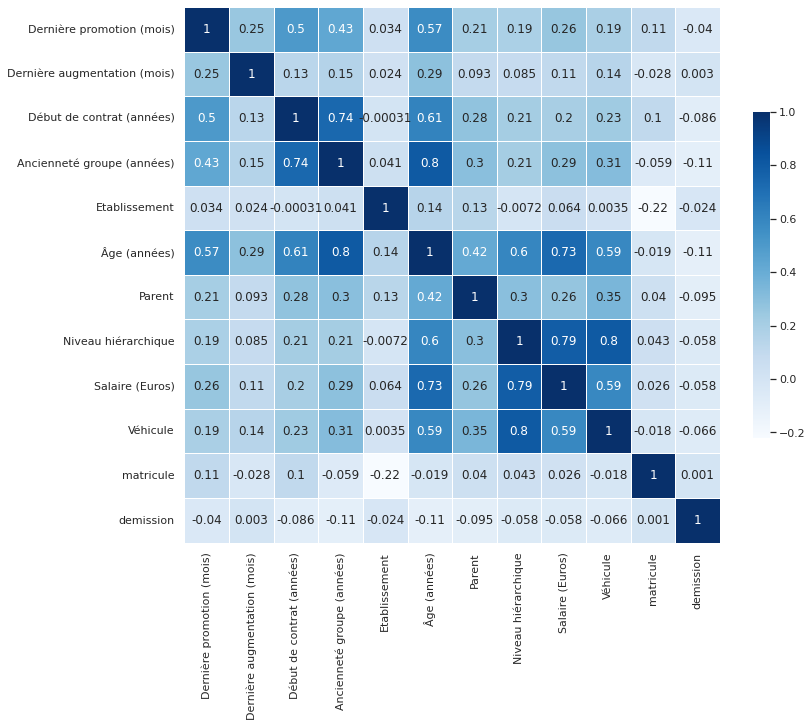

In [9]:
# Correlation matrix

df = X.copy()

# Add the label to the dataframe df to compute the correlation
df["demission"] = Y

corr = df.corr()
plt.figure(figsize=(12,12))
sns.heatmap(corr, cmap="Blues", annot=True, square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

Question: What do you notice regarding the target feature 'demission', which is what we will be trying to predict?

We can see that there is no strong correlation between `demission` and any other feature. But that doesn't mean that they are mutually independent, probably we can get good correlations when we combine features. 

Question: What interesting correlations do you notice (for instance with the feature 'Âge (années)' or 'Salaire') ?

Age and salary are positively correlated. That means, the more age increases, the more salary is expected to increase.

In [10]:
df.columns

Index(['Famille d'emploi', 'Dernière promotion (mois)',
       'Dernière augmentation (mois)', 'Début de contrat (années)',
       'Ancienneté groupe (années)', 'Etablissement', 'Âge (années)', 'Parent',
       'Niveau hiérarchique', 'Salaire (Euros)', 'Statut marital', 'Véhicule',
       'matricule', 'demission'],
      dtype='object')

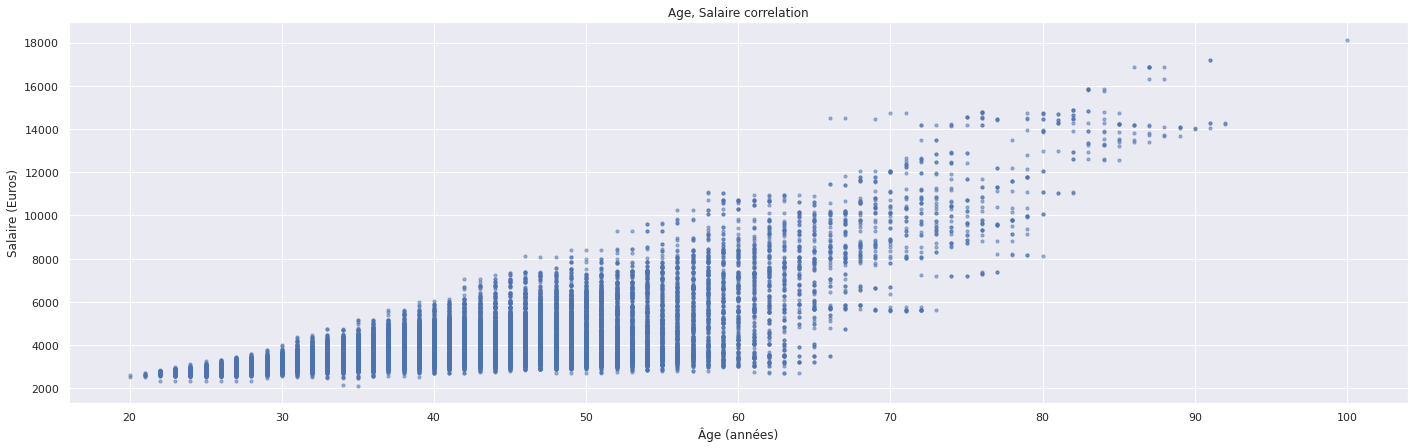

In [11]:
age_sal = df[["Âge (années)", "Salaire (Euros)"]].to_numpy()
age, sal = age_sal[:,0], age_sal[:,1]

plt.figure(figsize=(24,7))
plt.scatter(age, sal, s=10, alpha=0.5)
plt.title("Age, Salaire correlation")
plt.xlabel("Âge (années)")
plt.ylabel("Salaire (Euros)")
plt.show()

It can sometimes be useful to visualise the distribution of a particular set of features. First, we can try and visualise the age distribution for employees who resigned or didn't resign in the next 6 months. These distributions seem to indicate that the subgroup of employees who resigned are generally younger than the subgroup of employees who did not resign.

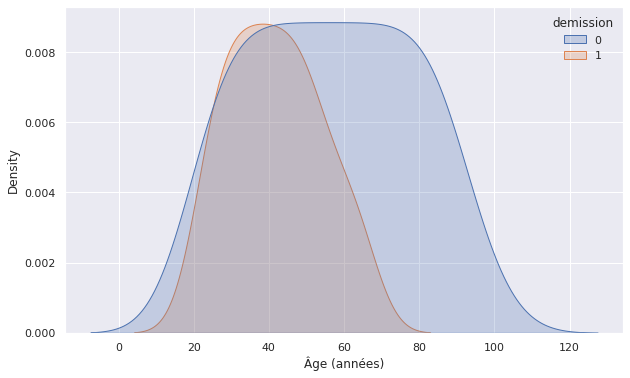

In [12]:
x,y = 'Âge (années)', 'demission'

plt.figure(figsize=(10,6))
sns.set_theme()
sns.kdeplot(data=df.groupby(x)[y].value_counts(normalize=True).mul(100), x=x, hue=y, fill=True)
plt.show()

It is very important to notice that the age range of resigned employees is much smaller than the age range of employees who did not resign and its mean is lower.

Question: How do you interpret this visualisation?

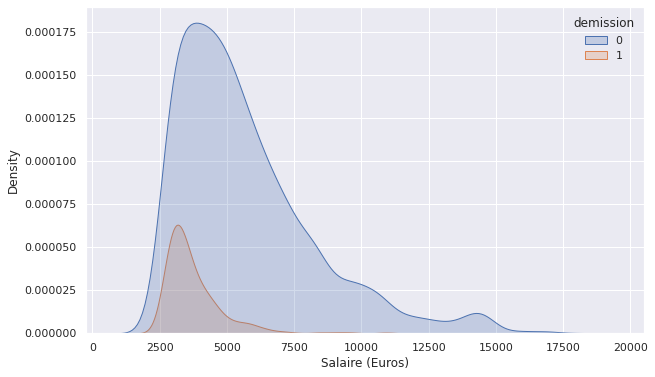

In [13]:
x,y = 'Salaire (Euros)', 'demission'

plt.figure(figsize=(10,6))
sns.set_theme()
sns.kdeplot(data=df.groupby(x)[y].value_counts(normalize=True).mul(100), x=x, hue=y, fill=True)
plt.show()

In [14]:
df.groupby(x)[y].value_counts(normalize=True).mul(100)

Salaire (Euros)  demission
2134             0            100.0
2137             0            100.0
2330             0            100.0
2332             0            100.0
2333             0            100.0
                              ...  
16889            0            100.0
16890            0            100.0
16891            0            100.0
17185            0            100.0
18137            0            100.0
Name: demission, Length: 5466, dtype: float64

Employees with a high salary are less likely to resign. The salary of resignated employees is meanly between 2500 and 5000 euros. It is also important to notice that employees with lowest salaries are not resigning, maybe they are juste waiting for a promotion ?

Question: How do you interpret this visualisation?

Similarly in this 2D plot, we can visualise the combination of salary and age with respect to the target variable 'demission'. The subgroup of employees who resigned have a generally smaller salary in addition to being younger.

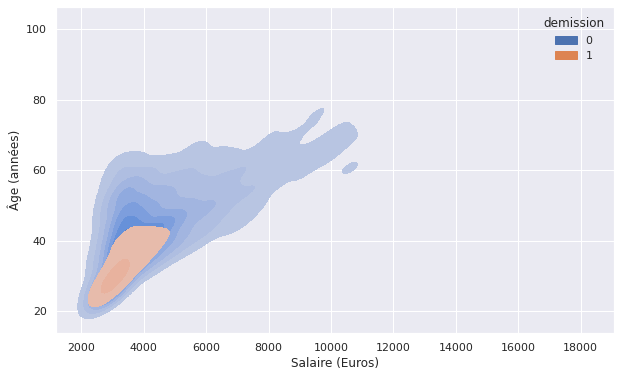

In [15]:
plt.figure(figsize=(10,6))
sns.set_theme()
sns.kdeplot(data=df, x="Salaire (Euros)", y="Âge (années)", hue="demission", fill=True)
plt.show()

As we can notice, employees that have a salary corresponding to their age (ie. the mean of the salary a this age) are more likely to resign below the age of 45. It is interesting to notice that employees with age 25 - 40 do not resigne when they have very low salaries, maybe they are waiting for a promotion or they have low qualifications that correspond to a low salary. This phenomenon is more observed for age 40 - 45.

Question: How do you interpret this visualisation?

Question : Do the parents tend to resignate more in the input dataset ?

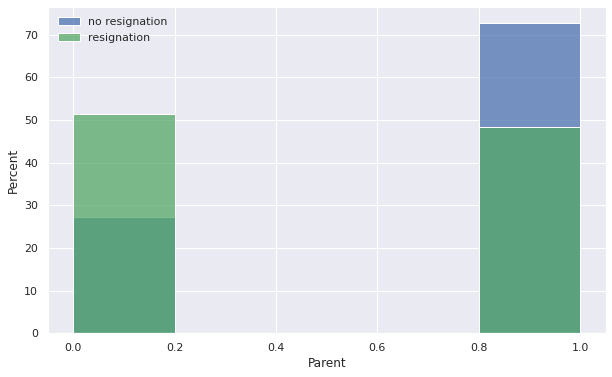

In [16]:
x,y = 'Parent', 'demission'


plt.figure(figsize=(10,6))
sns.set_theme()
sns.histplot(data=df[df[y] == 0], x=x, fill=True, stat="percent", binwidth= 0.2,color="b", label="no resignation")
sns.histplot(data=df[df[y] == 1], x=x, fill=True, stat="percent", binwidth= 0.2,color="g", label="resignation")
plt.legend()
plt.show()

Parents are less likely to resign than others

Question : How many months after their last promotion are the employees the most likely to leave the company according to the input data ?


In [17]:
print("In order to not repeat instances :")
df[df[y]==1].groupby("matricule")[x].last()

In order to not repeat instances :


matricule
1       1
5       0
7       1
17      0
19      0
       ..
2651    1
2655    0
2659    1
2660    0
2666    0
Name: Parent, Length: 408, dtype: int64

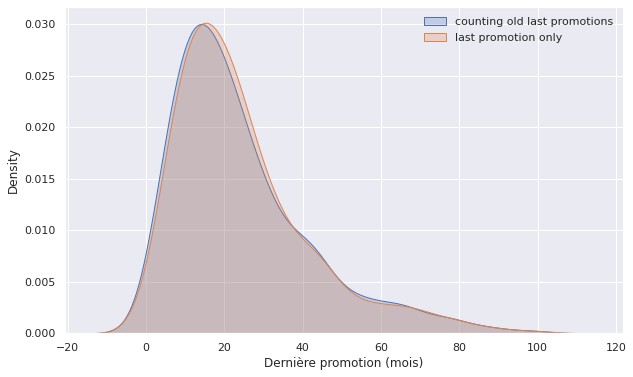

In [18]:

x,y = "Dernière promotion (mois)", "demission"
z=  "matricule"

plt.figure(figsize=(10,6))
sns.set_theme()
sns.kdeplot(data=df[df[y]==1].groupby(x)[y].value_counts(normalize=True).mul(100), x=x, fill=True, label="counting old last promotions")
sns.kdeplot(data=df[df[y]==1].groupby("matricule")[x].last(), fill=True, label="last promotion only")
plt.legend()
plt.show()

Employees with last promotion between 10 months to 40 months are more likeley to resign.

### Encode the dataset

The preliminar data exploration performed helps us discovering all the features in the dataset, their distributions and correlations. The categorical features have also been targeted. The *category_encoders* library will then be called to transform our previous dataset for a future ML implementation. This library is compatible with the *SHAPASH* library for explainability.

Two category_encoders are needed for our transformation :
- <a href="https://contrib.scikit-learn.org/category_encoders/onehot.html">OneHotEncoder</a>
- <a href="https://contrib.scikit-learn.org/category_encoders/ordinal.html">OrdinalEncoder</a>

In [19]:
# Pick the right features to encode
ONEHOT_ENC_FT = ["Famille d'emploi", "Etablissement", "Statut marital"]
ORDINAL_ENCODER = ["Niveau hiérarchique"]

onehot_encoder = OneHotEncoder(cols=ONEHOT_ENC_FT)
ordinal_encoder = OrdinalEncoder(cols=ORDINAL_ENCODER)

################
# Fit_transform - create a X_enc dataframe from the X dataframe
X_enc = onehot_encoder.fit_transform(X)
X_enc = ordinal_encoder.fit_transform(X_enc)

################
display(X_enc.head())
encoders = [onehot_encoder, ordinal_encoder]

,Famille d'emploi_1,Famille d'emploi_2,Famille d'emploi_3,Famille d'emploi_4,Famille d'emploi_5,Famille d'emploi_6,Famille d'emploi_7,Famille d'emploi_8,Dernière promotion (mois),Dernière augmentation (mois),...,Statut marital_2,Statut marital_3,Statut marital_4,Statut marital_5,Statut marital_6,Statut marital_7,Statut marital_8,Statut marital_9,Véhicule,matricule
0,1,0,0,0,0,0,0,0,8.510000,7.900000,...,0,0,0,0,0,0,0,0,0,32
1,1,0,0,0,0,0,0,0,35.119999,22.690001,...,0,0,0,0,0,0,0,0,1,1890
2,1,0,0,0,0,0,0,0,25.299999,22.139999,...,1,0,0,0,0,0,0,0,1,1847
3,1,0,0,0,0,0,0,0,5.240000,5.100000,...,0,1,0,0,0,0,0,0,0,2619
4,1,0,0,0,0,0,0,0,35.919998,22.840000,...,0,0,0,0,0,0,0,0,1,1963


### PCA

Dimensionality reduction is a powerful tool in machine learning to help Data Scientists visualise high-dimensional data in a 2D space. Once the reduction applied, the computational time is also considerably reduced. 

Data Scientists need to understand the trade off between information loss and simplicity of visualisation.

In [20]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler1 = StandardScaler()
x_pca = scaler1.fit_transform(X_enc)
pca = PCA(n_components=2)
principal_components = pca.fit_transform(x_pca)
pca_df = pd.DataFrame(data = principal_components
             , columns = ['principal component 1', 'principal component 2'])
pca_df['demission'] = Y
pca_df.head()

,principal component 1,principal component 2,demission
0,-1.812284,-0.650765,0
1,1.788514,-1.509211,0
2,1.966211,-0.566128,0
3,-3.533518,0.977363,1
4,1.538162,-0.763602,0


[]

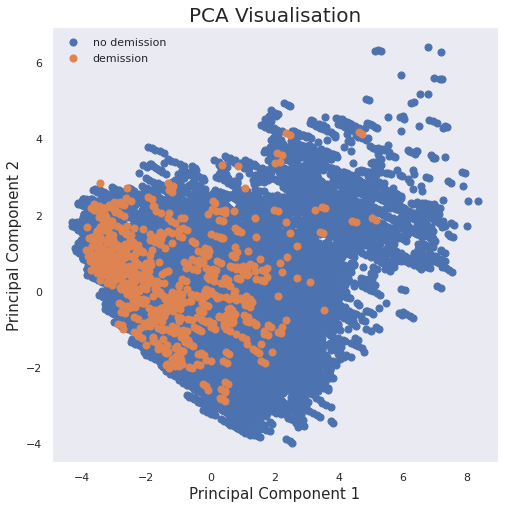

In [21]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('PCA Visualisation', fontsize = 20)
demission = [0, 1]
color = sns.color_palette().as_hex()

for dem, color in zip(demission,color):
    indicesToKeep = pca_df["demission"] == dem
    ax.scatter(pca_df.loc[indicesToKeep, 'principal component 1']
               , pca_df.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(['no demission', 'demission'])
ax.grid()
ax.plot()

Question: How do you interpret the results of the PCA? Is this PCA with 2 components reliable for a ML implementation ?

- This PCA didn't succed to correctly separated the two classes.

## ML implementation

The dataframe is now freshly encoded and ready to be fed to a machine learning model.

Nevertheless, a smart train/test split is required. As mentionned in the exploration part, around 2500 employees are gathered in the complete 23000-shaped dataset. A naive train/test split on the encoded dataframe with *scikit-learn* would definitely place the same employees (at different time steps) in the train and in the test splits. Such a split would bias the training of a ML model.

The train/test split needs therefore to be executed on the **matricules** to bring together all the time steps for each employees in the same subdataset (train or test).

### Train/test split

In [22]:
test_size = 0.2
random_state = 420
matricules = X_enc["matricule"].unique()

# TO COMPLETE
train_mat, test_mat = train_test_split(matricules, test_size =0.2, random_state=420)
train_indexes = X_enc[X_enc["matricule"].isin(train_mat)].index
test_indexes = X_enc[X_enc["matricule"].isin(test_mat)].index

X_train = X_enc.loc[train_indexes]
X_test = X_enc.loc[test_indexes]

Y_train = Y[train_indexes]
Y_test = Y[test_indexes]

# Assert distribution is the same

_, dist_init = np.unique(Y, return_counts=True)
_, dist_train = np.unique(Y_train, return_counts=True)
_, dist_test = np.unique(Y_test, return_counts=True)

print("Label distribution in the global dataset :", dist_init[1]/dist_init[0])
print("Label distribution in the train dataset :", dist_train[1]/dist_train[0])
print("Label distribution in the test dataset :", dist_test[1]/dist_test[0])

Label distribution in the global dataset : 0.03268115314691369
Label distribution in the train dataset : 0.03206823948604438
Label distribution in the test dataset : 0.035160515396374756


In [23]:
# Remove "matricule" feature

X_train.drop(columns=["matricule"], inplace=True)
X_test.drop(columns=["matricule"], inplace=True)

### Training with optuna

We use Optuna to run hyperparameters optimizations for the model chosen. To correctly use Optuna you need :

- A ML model
- an *objective* function with *trial* as argument.
    - Specify the hyperparameters to optimize (xgb_params for the XGBoost classifier)
    - Returns the score of the new training. This score needs either to be minimized (loss) or maximized (metric)

You'll find below an example for the Optuna implementation.

**A sample weight is recommended when implementing a RandomForestClassifier.** When it comes to XGBoost, it will not be necessary (because corrective weights are assigned during the training process).

The score chosen in the hyperparameters research is decisive. Please keep in mind that we are dealing with classification.

#### Random Forest

The Optuna objective function and the study to optimize the hyperparameters are shown in the couple cells below. As mentioned, a sample weight is computed to weight the loss function during the training.

In [24]:
# TO COMPLETE
# def compute_sample_weight(y, class_weight="balanced"):
#     """
#     Compute the sample weights for the training dataset.
#     """
#     if class_weight == "balanced":
#         weights = np.ones(len(y))
#         ones = sum(y)
#         zeros = len(y) - ones
#         weights[y == 0] = 1 / zeros
#         weights[y == 1] = 1 / ones
#         return weights
#     elif class_weight == "ones":
#         return np.ones(len(y))
# sample_weight = compute_sample_weight(Y_train ,class_weight="balanced")

sample_weight = compute_sample_weight(class_weight="balanced", y=Y_train)
display(sample_weight)

array([ 0.51603412,  0.51603412, 16.09175084, ...,  0.51603412,
        0.51603412,  0.51603412])

In [103]:
def objective_rf(trial):
    rf_params = {
        # Parameter space definition
        # 'n_estimators' : trial.suggest_int('n_estimators', ..., ...),
        "n_estimators" : trial.suggest_int('n_estimators', 10, 100),
        "criterion" : trial.suggest_categorical('criterion', ["gini", "entropy"]),
        "max_features" : trial.suggest_categorical('max_features', ["auto", "sqrt", "log2"]),
        "max_depth" : trial.suggest_int('max_depth', 1, 50),
    }
        
    rf_classifier = RandomForestClassifier(random_state=42)
    rf_classifier.set_params(**rf_params)
    rf_classifier.fit(X_train, Y_train, sample_weight=sample_weight)
    Y_pred = rf_classifier.predict(X_test)
    score = roc_auc_score(Y_test, Y_pred)
    # score = f1_score(Y_test, Y_pred)
    
    return score


In [104]:
study = optuna.create_study(direction="maximize")
full_objective = lambda trial: objective_rf(trial)
study.optimize(full_objective, n_trials=60, timeout=600)
rf_params = study.best_trial.params

[I 2022-04-14 09:58:13,929] A new study created in memory with name: no-name-91e6889b-0cb2-4f8a-a581-b897610765fe
[I 2022-04-14 09:58:15,337] Trial 0 finished with value: 0.49945402926403143 and parameters: {'n_estimators': 62, 'criterion': 'gini', 'max_features': 'auto', 'max_depth': 36}. Best is trial 0 with value: 0.49945402926403143.
[I 2022-04-14 09:58:17,447] Trial 1 finished with value: 0.5166551594573662 and parameters: {'n_estimators': 80, 'criterion': 'entropy', 'max_features': 'auto', 'max_depth': 23}. Best is trial 1 with value: 0.5166551594573662.
[I 2022-04-14 09:58:19,295] Trial 2 finished with value: 0.4997816117056126 and parameters: {'n_estimators': 80, 'criterion': 'gini', 'max_features': 'sqrt', 'max_depth': 38}. Best is trial 1 with value: 0.5166551594573662.
[I 2022-04-14 09:58:20,954] Trial 3 finished with value: 0.5252075706133456 and parameters: {'n_estimators': 94, 'criterion': 'gini', 'max_features': 'log2', 'max_depth': 23}. Best is trial 3 with value: 0.525

/home/mus5900/anaconda3/envs/series_forcasting/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



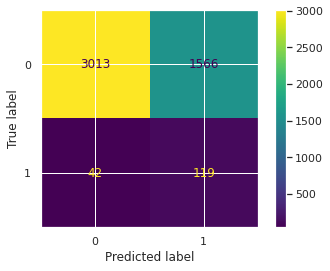

In [105]:
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.set_params(**rf_params)
rf_clf.fit(X_train, Y_train, sample_weight=sample_weight)
plot_confusion_matrix(rf_clf, X_test, Y_test)

Question : Comment the confusion matrix for the Random Forest Classifier. How many false positives ?

- The confusion matrix shows that the model is making a lot of mistakes, especially the False positives.

- The high ROC auc score doesn't guarantee that the model is able to distinguish between the two classes.

- It was possible to use the f1-score.

Question : Compute the precision and recall for the resignation class (1).

In [102]:
Y_pred = rf_clf.predict(X_test)

print("********")
print("For class 1 ")
print("********")
print("\tprecision score :", precision_score(Y_test, Y_pred))
print("\trecall score :", recall_score(Y_test, Y_pred))
print("\tf1-score score :", f1_score(Y_test, Y_pred))

print("********")
print("For class 0 ")
print("********")
print("\tprecision score :", precision_score(1-Y_test, 1-Y_pred))
print("\trecall score :", recall_score(1-Y_test, 1-Y_pred))
print("\tf1-score score :", f1_score(1-Y_test, 1-Y_pred))

********
For class 1 
********
	precision score : 0.08885163453478626
	recall score : 0.6583850931677019
	f1-score score : 0.15657311669128507
********
For class 0 
********
	precision score : 0.984493938539611
	recall score : 0.7626119240008735
	f1-score score : 0.8594634506522275


#### XGBoost

Let's use XGBoost to improve the RandomForest performances. The boosting method automatically assigns corrective weights to mispredicted data samples. 

In [ ]:
# TO COMPLETE

def objective(trial):
    xgb_params = {
            # Parameter space definition
            "n_estimators" : trial.suggest_int('n_estimators', 10, 120),
            "learning_rate" : trial.suggest_float('learning_rate', 0.001, 0.5, log=True),
            "max_depth" : trial.suggest_int('max_depth', 1, 50),
            "colsample_bytree": trial.suggest_loguniform("colsample_bytree", 0.2, 0.6),
            "subsample": trial.suggest_loguniform("subsample", 0.4, 0.8),
            "alpha": trial.suggest_loguniform("alpha", 0.01, 10.0),
            "lambda": trial.suggest_loguniform("lambda", 1e-8, 10.0),
            "gamma": trial.suggest_loguniform("lambda", 1e-8, 10.0),
            "min_child_weight": trial.suggest_loguniform("min_child_weight", 10, 1000),
            "scale_pos_weight": trial.suggest_int("scale_pos_weight", 1, 100),
            "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        }

    xgb_classifier = XGBClassifier(objective='binary:logistic', eval_metric='auc', use_label_encoder=False)
    xgb_classifier.set_params(**xgb_params)
    xgb_classifier.fit(X_train, Y_train, sample_weight=None)
    Y_pred = xgb_classifier.predict(X_test)
    score = roc_auc_score(Y_test, Y_pred)
    # score = f1_score(Y_test, Y_pred)
    return score

# study = optuna.create_study(direction="minimize") for a loss scoring
study = optuna.create_study(direction="maximize")
full_objective = lambda trial: objective(trial)
study.optimize(full_objective, n_trials=300, timeout=1600)
xgb_params = study.best_trial.params

In [85]:
xgb_params

{'n_estimators': 75,
 'learning_rate': 0.32851874215234755,
 'max_depth': 49,
 'colsample_bytree': 0.4990675742290582,
 'subsample': 0.6702165168717255,
 'alpha': 3.397063322319743,
 'lambda': 1.0378118323821677,
 'min_child_weight': 654.6457964403456,
 'scale_pos_weight': 43,
 'booster': 'gbtree'}

Once the hyperparameter search is over, train a classifier with the best parameters on the complete dataset.

In [120]:
all_sample_weight = compute_sample_weight(class_weight="balanced", y=Y)

clf = XGBClassifier(objective="binary:logistic", use_label_encoder=False)
clf.set_params(**xgb_params)
# clf.fit(X_enc.drop(columns=["matricule"]), Y, sample_weight=all_sample_weight)
clf.fit(X_enc.drop(columns=["matricule"]), Y, sample_weight=None)

[10:08:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(alpha=3.397063322319743, base_score=0.5, booster='gbtree',
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.4990675742290582, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', lambda=1.0378118323821677,
              learning_rate=0.32851874215234755, max_delta_step=0, max_depth=49,
              min_child_weight=654.6457964403456, missing=nan,
              monotone_constraints='()', n_estimators=75, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=3.39706326, reg_lambda=1.03781188, scale_pos_weight=43,
              subsample=0.6702165168717255, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, ...)

/home/mus5900/anaconda3/envs/series_forcasting/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



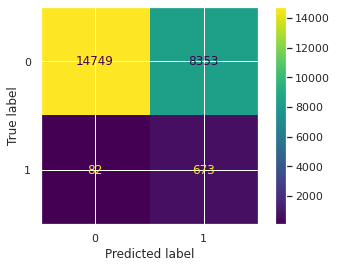

In [121]:
plot_confusion_matrix(clf, X_enc.drop(columns=['matricule']), Y)

Question : Compare this new confusion matrix to the RF one. Give the precision and recall for the class 1.

In [123]:
Y_pred = clf.predict(X_test)

print("********")
print("For class 1 ")
print("********")
print("\tprecision score :", precision_score(Y_test, Y_pred))
print("\trecall score :", recall_score(Y_test, Y_pred))
print("\tf1-score score :", f1_score(Y_test, Y_pred))

print("********")
print("For class 0 ")
print("********")
print("\tprecision score :", precision_score(1-Y_test, 1-Y_pred))
print("\trecall score :", recall_score(1-Y_test, 1-Y_pred))
print("\tf1-score score :", f1_score(1-Y_test, 1-Y_pred))

********
For class 1 
********
	precision score : 0.08642691415313225
	recall score : 0.9254658385093167
	f1-score score : 0.15809018567639258
********
For class 0 
********
	precision score : 0.9960212201591512
	recall score : 0.6560384363398122
	f1-score score : 0.7910467412771559


- This confusion matrix is not really better than the random forest one, especially that here we evaluate over the training set. The only advantage here is simply that the class 1 is better predicted.

Our model has trained on the full dataset. Let's try to understand how the classification was performed, which features are the most relevant, how they contribute to the final decision ...

## Explainability with Shapley values

<a href="https://christophm.github.io/interpretable-ml-book/shapley.html">Shapley values</a> are common coefficients to quantify the contributions of each features in the predictions of the model. Theoretically, *coalitions* are made to observe the influence of a selected feature in the prediction. The contribution is computed by comparing the predictions with and without this feature.

The computation can take a while, especially on large dataset. The contribution computation is thus often made on random subsets.

In [124]:
from shapash.explainer.smart_explainer import SmartExplainer

input_ex = X_enc.drop(columns=["matricule"])

xpl = SmartExplainer(label_dict={0: 'Pas de démission', 1:'Démission'})
xpl.compile(
        x=input_ex,
        preprocessing=encoders,
        model=clf
        )

Backend: Shap TreeExplainer


/home/mus5900/anaconda3/envs/series_forcasting/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.



In [125]:
xpl.plot.contribution_plot(col="Âge (années)")

Question : Compare the contributions for young and old employees. Did you expect such a difference ? Why ?

- It seems that for the age lower than 40:
    - The age contributes positively to the prediction.
- For age above 400 :
    - The age contributes negatively to the prediction but with a high impact starting from age 50.
- This difference was expected when we were doing vizuualisation of the dataset.


Question : A colored scale is displayed in the right part of the graph, representing a "Predicted probability" for demission. How does the predicted probability evolve with the SHAP contribution ? What do you conclude about the importance of the "Âge (années)" feature ?

- The predicted probability shows :
    - The age effect is very reliable, as we can see the majority of those points where age contributed positively, they have been yielded with high probability ("démission") and the same for those where the age contributed negatively, they have been yielded with low proba.

In [126]:
xpl.plot.contribution_plot(col="Ancienneté groupe (années)")

Question : Explain the "Ancienneté groupe (années)" contribution plot. How is it correlated with the "Âge (années)" contribution plot?

- This plot is a bit chaotic.
- For very low values, the contribution is positive and negative when the values are low
- The correlation the age plot :
    - For higher ancienneté, the same as higher age, the model predicts with the best confidence that the prediction is "non démission".

Question : What can you infer about the feature importance ?

In [127]:
xpl.plot.contribution_plot(col="Statut marital")

- We can infer that some marital situation are non conclusive as they contribute negatively and positively to the prediction like "PACS" or "Marié".
- It is important to note that marital status does distinguish (not always) between the two classes, for example : for célibataire does have hot values in the top and cold ones in the bottom. But it is still a problem that those points have been contributed negatively.

Question : What do you notice about the median contributions of all the values for the "Statut marital" feature ? 

- There is only one positive median contribution which is for the Marié feature. 

Question : Take a look at the "Célibataire" and "Marié(e)" contributions. What do you think ? What do you conclude about the relevance of this feature during the training process ?

- It is good to notice that "Célibataire" feature tend towards negative values "Pas de démission" in contrast to "Marié" feature. Maybe that is explained by the fact that maried people do have their partnersto help them, so they have less pressure and risk for changing their job

In [129]:
xpl.plot.contribution_plot(col="Parent")

Question : Explain the contribution plot. Does this contribution plot makes sense ? (in your opinion and compared to the input data ?)

- This was expected from the data vizualisation step.

In [130]:
xpl.plot.features_importance()

Question : The feature importance is finally displayed. How do you build such a graph having computed the contributions of every feature independantly ?

## Feature selection for model's improvements

Now that the feature importances are displayed, one can select the decisive ones, study their contributions to the predictions of the model. 

We propose to select features according to their contribution and feature importance plots, in order to improve the baseline of the previous XGBoost model.

**Previous baseline : AUC_ROC_CURVE = 0.701**

Question : According to the previous contribution plots, which features are to be removed to try to improve the baseline ? (other contribution plots can be displayed)

In [ ]:
with open(PATH, 'rb') as read_file:
    X, Y = pickle.load(read_file)
display(X.head())

# TO COMPLETE
selected_columns = ["...", "..."]

selected_columns.append('matricule')
X = X[selected_columns]
display(X.head())

In [ ]:
from category_encoders import OneHotEncoder, OrdinalEncoder as OrdinalEncoder_ce

# TO COMPLETE
ONEHOT_ENC_FT = ["..."]

onehot_encoder = OneHotEncoder(cols=ONEHOT_ENC_FT).fit(X)
X_enc = onehot_encoder.transform(X)

encoders = [onehot_encoder]

In [ ]:
# Train, test par matricule
test_size = 0.2
matricules = X_enc["matricule"].unique()

mat_train, mat_test = train_test_split(matricules, test_size=0.2, random_state=420)
idx_mat_train = X_enc[X_enc["matricule"].isin(mat_train)].index
idx_mat_test = X_enc[X_enc["matricule"].isin(mat_test)].index

X_train = X_enc.loc[idx_mat_train].reset_index(drop=True)
X_test = X_enc.loc[idx_mat_test].reset_index(drop=True)

Y_train = Y[idx_mat_train]
Y_test = Y[idx_mat_test]

# Assert distribution is the same

_, dist_init = np.unique(Y, return_counts=True)
_, dist_train = np.unique(Y_train, return_counts=True)
_, dist_test = np.unique(Y_test, return_counts=True)

print(dist_init[1]/dist_init[0])
print(dist_train[1]/dist_train[0])
print(dist_test[1]/dist_test[0])

In [ ]:
# Remove "matricule" feature

X_train.drop(columns=["matricule"], inplace=True)
X_test.drop(columns=["matricule"], inplace=True)

In [ ]:
def objective(trial):
    xgb_params = {
            # Parameter space definition
            # ...
            # ...
        }

    xgb_classifier = XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False)
    xgb_classifier.set_params(**xgb_params)
    xgb_classifier.fit(X_train, Y_train, sample_weight=None)
    Y_pred = xgb_classifier.predict(X_test)
    # score = 
    return score

In [ ]:
study = optuna.create_study(direction="maximize")
full_objective = lambda trial: objective(trial)
study.optimize(full_objective, n_trials=60, timeout=600)
xgb_params = study.best_trial.params

Question : Dit it improve the previous score compared to the baseline ?

If not, consider other features to remove, or try to consider the correlations between the input features to avoid redundancy during the training process...